In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch

!pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster  --y
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install git+https://github.com/pyg-team/pytorch_geometric.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 63.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 56.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu118.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 60.0 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/pyg-team/pytorch_geometric.git to /tmp/pip-req-build-40u6njeu
  Running command git clone --filter=blob:none --quiet https://github.com/py

In [3]:

import torch
import numpy as np
import pandas as pd
from torch_geometric.data import Data, Dataset
from itertools import product

class EEGGraphDataset(Dataset):
	def __init__(self, X, y, indices, loader_type, sfreq, transform=None):

		self.epochs = X
		self.labels = y
		self.indices = indices
		self.sfreq = sfreq
		self.loader_type = loader_type
		self.transform = transform

		self.ch_names = ['EEG FP1','EEG FP2','EEG F3','EEG F4','EEG C3','EEG C4','EEG P3','EEG P4','EEG O1','EEG O2','EEG F7','EEG F8','EEG T3','EEG T4','EEG T5','EEG T6','EEG FZ','EEG CZ','EEG PZ']
		self.ref_names = ['EEG FP1','EEG FP2','EEG F3','EEG F4','EEG C3','EEG C4','EEG P3','EEG P4','EEG O1','EEG O2','EEG F7','EEG F8','EEG T3','EEG T4','EEG T5','EEG T6','EEG FZ','EEG CZ','EEG PZ']

		self.node_ids = range(len(self.ch_names))
		self.edge_index = torch.tensor([[a,b] for a, b in product(self.node_ids, self.node_ids)], dtype=torch.long).t().contiguous()
		self.distances = self.get_sensor_distances()
		a = np.array(self.distances)
		self.distances = (a - np.min(a))/(np.max(a) - np.min(a))

	def get_sensor_distances(self):
		num_edges = self.edge_index.shape[1]
		distances = [ ]
		for edge_idx in range(num_edges): 
			sensor1_idx = self.edge_index[0, edge_idx]
			sensor2_idx = self.edge_index[1, edge_idx]
			dist = self.get_geodesic_distance(sensor1_idx, sensor2_idx)
			distances.append(dist)
		assert len(distances) == num_edges
		return distances

	def get_geodesic_distance(self, montage_sensor1_idx, montage_sensor2_idx):
		
		ref_sensor1 = self.ref_names[montage_sensor1_idx]
		ref_sensor2 = self.ref_names[montage_sensor2_idx]
		distances = pd.read_csv('./drive/MyDrive/ML_Project/distances_3d.csv')
		for row in range(int(distances.shape[0])):
			if(distances.iloc[row][0]==ref_sensor1 and distances.iloc[row][1]==ref_sensor2):
				return distances.iloc[row][2]
			if(distances.iloc[row][1]==ref_sensor1 and distances.iloc[row][0]==ref_sensor2):
				return distances.iloc[row][2]
		return 0

	def __len__(self):
		return len(self.indices)

	def __getitem__(self, idx):
		if torch.is_tensor(idx):
			idx = idx.tolist()
		idx = self.indices[idx]
		node_features = self.epochs[idx]
		node_features = torch.from_numpy(node_features.reshape(19, 6))
		
		edge_weights = self.distances 
		edge_weights = torch.tensor(edge_weights)
		data = Data(x=node_features, edge_index=self.edge_index, edge_attr=edge_weights,dataset_idx=idx, y=self.labels[idx])
		return data

	def len(self):
		return self.__len__(self.indices)
	
	def get(self, idx):
		return self.__getitem__(idx)
	


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool, BatchNorm, global_add_pool


class EEGGraphConvNet(nn.Module):
    def __init__(self, reduced_sensors=None, sfreq=None):
        super(EEGGraphConvNet, self).__init__()
		
        self.sfreq = sfreq
        self.input_size = 19

        self.conv1 = GCNConv(6, 200, improved=True, cached=True, normalize=False)
        self.conv2 = GCNConv(200, 600, improved=True, cached=True, normalize=False)
        self.conv3_bn = BatchNorm(600, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)

        self.fc_block1 = nn.Linear(600, 400)
        self.fc_block2 = nn.Linear(400,64)
        self.fc_block3 = nn.Linear(64, 9)
    
    def forward(self, x, edge_index, edge_weight, batch, return_graph_embedding=False):
        x = F.leaky_relu(self.conv1(x, edge_index, edge_weight))
        x = F.leaky_relu(self.conv3_bn(self.conv2(x, edge_index, edge_weight)))
        out = global_add_pool(x, batch=batch)
        if return_graph_embedding:
            return out
        out = F.leaky_relu(self.fc_block1(out), negative_slope=0.01)
        out = F.dropout(out, p = 0.2, training=self.training)
        out = F.leaky_relu(self.fc_block2(out), negative_slope=0.01)
        out = F.dropout(out, p = 0.2, training=self.training)
        out = self.fc_block3(out)
        return out

(31423, 114) (31423,)
Unique labels to 0-9 mapping: ['ABSZ' 'BCKG' 'CPSZ' 'FNSZ' 'GNSZ' 'MYSZ' 'SPSZ' 'TCSZ' 'TNSZ']
Epoch: 0--- | Accuracy : 0.631, Loss: 0.971 | Validation Accuracy : 0.345
Epoch: 1--- | Accuracy : 0.705, Loss: 0.776 | Validation Accuracy : 0.248
Epoch: 2--- | Accuracy : 0.727, Loss: 0.722 | Validation Accuracy : 0.279
Epoch: 3--- | Accuracy : 0.742, Loss: 0.683 | Validation Accuracy : 0.457
Epoch: 4--- | Accuracy : 0.756, Loss: 0.649 | Validation Accuracy : 0.345
Epoch: 5--- | Accuracy : 0.768, Loss: 0.621 | Validation Accuracy : 0.400
Epoch: 6--- | Accuracy : 0.777, Loss: 0.598 | Validation Accuracy : 0.464
Epoch: 7--- | Accuracy : 0.787, Loss: 0.578 | Validation Accuracy : 0.405
Epoch: 8--- | Accuracy : 0.793, Loss: 0.561 | Validation Accuracy : 0.408
Epoch: 9--- | Accuracy : 0.799, Loss: 0.546 | Validation Accuracy : 0.307
Epoch: 10--- | Accuracy : 0.825, Loss: 0.474 | Validation Accuracy : 0.887
Epoch: 11--- | Accuracy : 0.831, Loss: 0.460 | Validation Accuracy :

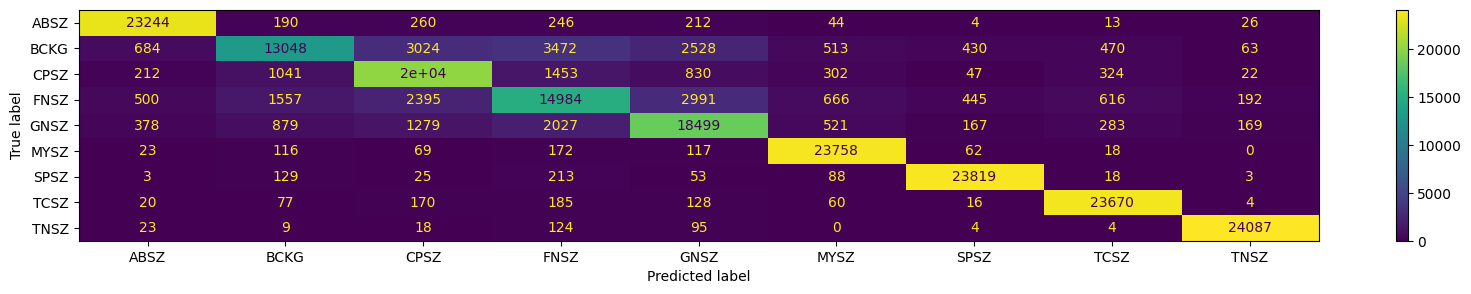

In [5]:
from sklearn.model_selection import train_test_split

from joblib import load
import statistics as stats
from sklearn import preprocessing

import torch.backends.cudnn as cudnn
cudnn.enabled = True
cudnn.benchmark = False
cudnn.deterministic = True

from torch_geometric.loader import DataLoader
from torch.utils.data import WeightedRandomSampler
from sklearn.metrics import make_scorer
from sklearn.metrics import balanced_accuracy_score, auc, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
from torchvision.transforms import Compose, ToTensor
import sklearn.metrics
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import random
from imblearn.over_sampling import SMOTE

sm = SMOTE()

def get_patient_prediction(df, fold_idx):
	unique_patients = list(df["patient_ID"].unique())
	grouped_df = df.groupby("patient_ID")
	rows = [ ]
	for patient in unique_patients:
		patient_df = grouped_df.get_group(patient)
		temp = { }
		temp["patient_ID"] = patient
		temp["y_true"] = list(patient_df["y_true"].unique())[0]
		temp["y_pred"] = patient_df["y_pred"].mode()[0]
		temp["y_probs"] = patient_df["y_probs"].mean()
		rows.append(temp)
	return_df = pd.DataFrame(rows)

	return np.array(list(return_df["y_probs"])), list(return_df["y_true"]), list(return_df["y_pred"])


if __name__ == "__main__":

	GPU_IDX = 0
	EXPERIMENT_NAME = "eeg_gnn"
	BATCH_SIZE = 32
	SFREQ = 250.0
	EPOCHS = 50
	WORKERS = 2

	MASTER_DATASET_INDEX = 7200
	train_indices = []
	test_subjects = []
	val_indices = []
	rem_subjects = []

	DEVICE = torch.device('cuda:{}'.format(GPU_IDX) if torch.cuda.is_available() else 'cpu')
	
	X = np.load("./drive/MyDrive/ML_Project/X_psd_epilepsy_corpus.npy", allow_pickle=True)
	y = np.load("./drive/MyDrive/ML_Project/y_epilepsy_corpus.npy", allow_pickle=True)
	print(X.shape, y.shape)
	
	X, y = sm.fit_resample(X, y)
	X, y = np.array(X), np.array(y) 
	
	indices = []
	for i in range(len(y)):
		indices.append(i)
	train_indices, test_subjects = train_test_split(indices, test_size=0.10)
	train_indices, val_indices = train_test_split(train_indices, test_size=0.10)
	
	normd_x = []
	for i in range(len(y)):
		arr = X[i, :]
		arr = arr.reshape(1, -1)
		arr2 = preprocessing.normalize(arr)
		arr2 = arr2.reshape(19*6)
		normd_x.append(arr2)
	
	norm = np.array(normd_x)
	X = norm.reshape(len(y), 19*6)

	label_mapping, y = np.unique(y, return_inverse = True)
	print("Unique labels to 0-9 mapping:", label_mapping)

	model = EEGGraphConvNet(reduced_sensors=False)
	model = model.to(DEVICE).double()

	labels_unique, counts = np.unique(y, return_counts=True)
	xtrain, ytrain, xval, yval, xtest, ytest=[],[],[],[],[],[]
	for i in train_indices:
		xtrain.append(X[i])
		ytrain.append(y[i])
	for i in val_indices:
		xval.append(X[i])
		yval.append(y[i])
	for i in test_subjects:
		xtest.append(X[i])
		ytest.append(y[i])
	xtrain, ytrain, xval, yval, xtest, ytest = np.array(xtrain), np.array(ytrain), np.array(xval), np.array(yval), np.array(xtest), np.array(ytest)
	
	train_dataset = EEGGraphDataset(X=xtrain, y=ytrain, indices=[i for i in range(len(xtrain))], loader_type="train", sfreq=SFREQ, transform=Compose([ToTensor()]))
	train_loader = DataLoader(dataset=train_dataset, shuffle=False, batch_size = BATCH_SIZE, num_workers = WORKERS)
	
	val_dataset = EEGGraphDataset(X=xval, y=yval, indices=[i for i in range(len(xval))], loader_type="validation", sfreq=SFREQ, transform=Compose([ToTensor()]))
	val_loader = DataLoader(dataset=val_dataset, shuffle=False, batch_size = BATCH_SIZE, num_workers = WORKERS)

	loss_function = torch.nn.CrossEntropyLoss()
	optimizer = torch.optim.Adam(model.parameters(), lr=5e-04) #torch.optim.Adam(model.parameters(),lr = 5e-04)
	scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[i*10 for i in range(1, 26)], gamma=0.1)

	accuracy_pts = []
	validation_accuracy_pts = []
	loss_pts = []
	x_params = []

	for epoch in range(EPOCHS):

		model.train()
		train_loss = []
		val_loss = []

		y_probs_train = torch.empty(0, 9).to(DEVICE)

		y_true_train = [ ]
		y_pred_train = [ ]
		window_indices_train = [ ]
		losses = 0.0
		for batch_idx, batch in enumerate(train_loader):

			X_batch = batch.to(device=DEVICE, non_blocking=True)
			y_batch = torch.tensor(batch.y)
			y_batch = y_batch.to(device=DEVICE, non_blocking=True)
			window_indices_train += X_batch.dataset_idx.cpu().numpy().tolist()
			optimizer.zero_grad()
			outputs = model(X_batch.x, X_batch.edge_index, X_batch.edge_attr, X_batch.batch).float()
			loss = loss_function(outputs, y_batch)
			losses += loss.item()
			train_loss.append(loss.item())
			loss.backward()

			_, predicted = torch.max(outputs.data, 1)
			y_pred_train += predicted.cpu().numpy().tolist()

			y_probs_train = torch.cat((y_probs_train, outputs.data), 0)
			y_true_train += y_batch.cpu().numpy().tolist()

			optimizer.step()
		scheduler.step()
		epoch_loss = losses / len(train_loader)
		loss_pts.append(epoch_loss)
		y_probs_train = torch.nn.functional.softmax(y_probs_train, dim=1).cpu().numpy()
		y_true_train = np.array(y_true_train)

		model.eval()
		with torch.no_grad():
			y_probs_val = torch.empty(0, 9).to(DEVICE)

			y_true_val = [ ]
			y_pred_val = [ ]
			window_indices_val = [ ]

			for i, batch in enumerate(val_loader):
				X_batch = batch.to(device=DEVICE, non_blocking=True)
				y_batch = torch.tensor(batch.y)
				y_batch = y_batch.to(device=DEVICE, non_blocking=True)
				window_indices_val += X_batch.dataset_idx.cpu().numpy().tolist()
				outputs = model(X_batch.x, X_batch.edge_index, X_batch.edge_attr, X_batch.batch).float()

				loss = loss_function(outputs, y_batch)
				val_loss.append(loss.item())

				_, predicted = torch.max(outputs.data, 1)
				y_pred_val += predicted.cpu().numpy().tolist()

				y_probs_val = torch.cat((y_probs_val, outputs.data), 0)
				y_true_val += y_batch.cpu().numpy().tolist()

		y_probs_val = torch.nn.functional.softmax(y_probs_val, dim=1).cpu().numpy()
		y_true_val = np.array(y_true_val)

		print(f'Epoch: {epoch}---', end=" | ")
		print(f"Accuracy : {sklearn.metrics.accuracy_score(y_true_train, y_pred_train):.3f}, Loss: {loss_pts[-1]:.3f}", end=" | ")
		print(f"Validation Accuracy : {sklearn.metrics.accuracy_score(y_true_val, y_pred_val):.3f}")
		accuracy_pts.append(sklearn.metrics.accuracy_score(y_true_train, y_pred_train))
		validation_accuracy_pts.append(sklearn.metrics.accuracy_score(y_true_val, y_pred_val))
		x_params.append(epoch+1)

	confusion_matrix = sklearn.metrics.confusion_matrix(y_true_train, y_pred_train)
	cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = label_mapping)
	plt.rcParams["figure.figsize"] = (20,3)
	cm_display.plot()
	plt.axis('tight')
	plt.show()

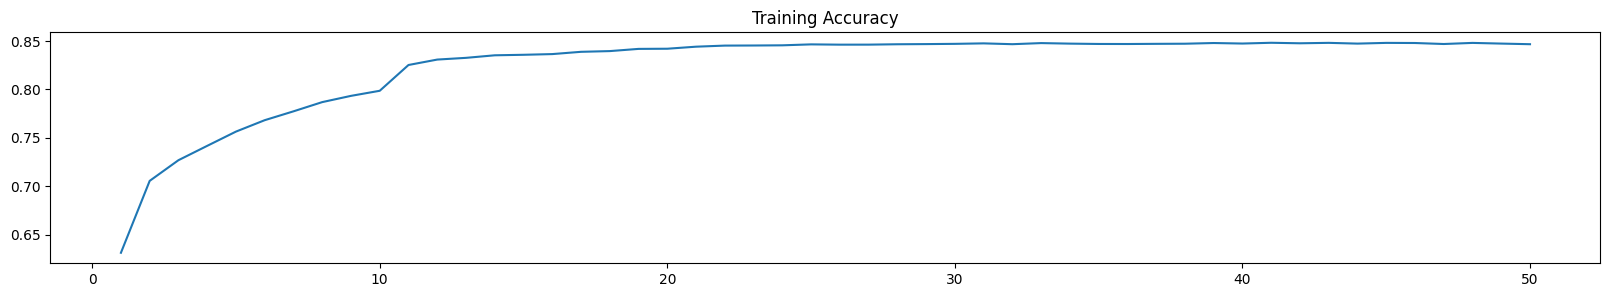

In [6]:
plt.title("Training Accuracy")
plt.plot(x_params[:EPOCHS], accuracy_pts[:EPOCHS])

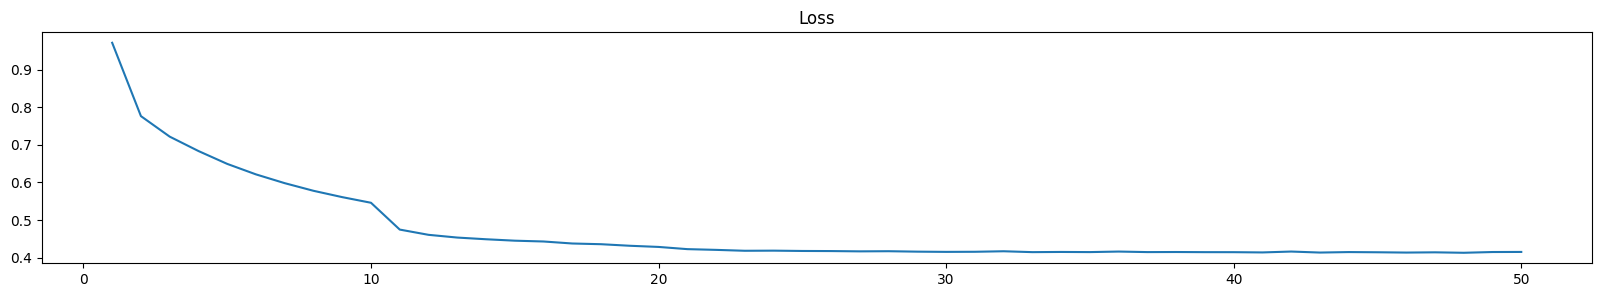

In [7]:

plt.title("Loss")
plt.plot(x_params[:EPOCHS], loss_pts[:EPOCHS])

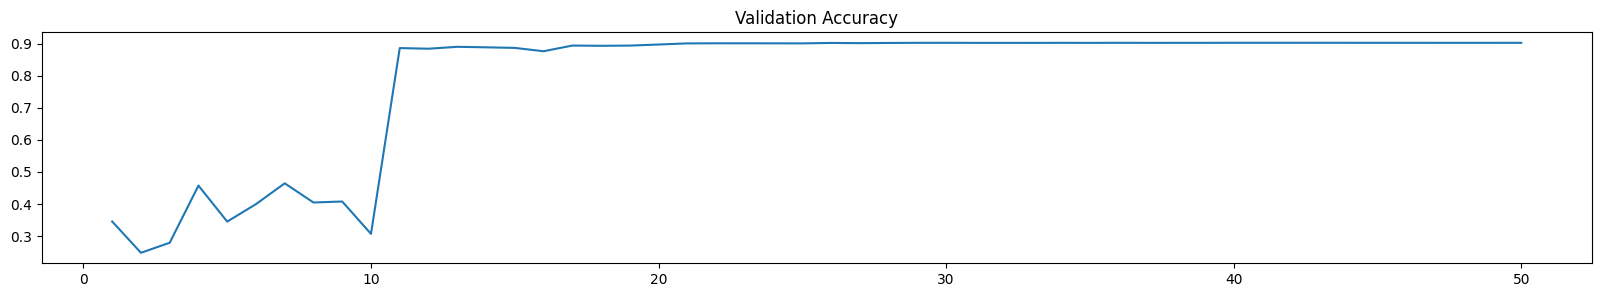

In [8]:
plt.title("Validation Accuracy")
plt.plot(x_params[:EPOCHS], validation_accuracy_pts[:EPOCHS])

In [9]:
test_dataset = EEGGraphDataset(X=xtest, y=ytest, indices=[i for i in range(len(xtest))], loader_type="validation", sfreq=SFREQ, transform=Compose([ToTensor()]))
test_loader = DataLoader(dataset=test_dataset, shuffle=False, batch_size = BATCH_SIZE, num_workers = WORKERS)
model.eval()
with torch.no_grad():
	y_probs_val = torch.empty(0, 9).to(DEVICE)
	y_true_val = [ ]
	y_pred_val = [ ]
	window_indices_val = [ ]
	try:
		for i, batch in enumerate(test_loader):
			X_batch = batch.to(device=DEVICE, non_blocking=True)
			y_batch = torch.tensor(batch.y)
			y_batch = y_batch.to(device=DEVICE, non_blocking=True)
			window_indices_val += X_batch.dataset_idx.cpu().numpy().tolist()
			try:
				outputs = model(X_batch.x, X_batch.edge_index, X_batch.edge_attr, X_batch.batch).float()
				loss = loss_function(outputs, y_batch)
				val_loss.append(loss.item())
				_, predicted = torch.max(outputs.data, 1)
				y_pred_val += predicted.cpu().numpy().tolist()
				y_probs_val = torch.cat((y_probs_val, outputs.data), 0)
				y_true_val += y_batch.cpu().numpy().tolist()
			except:
				pass
	except:
		pass
y_probs_val = torch.nn.functional.softmax(y_probs_val, dim=1).cpu().numpy()
y_true_val = np.array(y_true_val)
print(f"Test Accuracy : {sklearn.metrics.accuracy_score(y_true_val, y_pred_val):.3f}")

Test Accuracy : 0.900


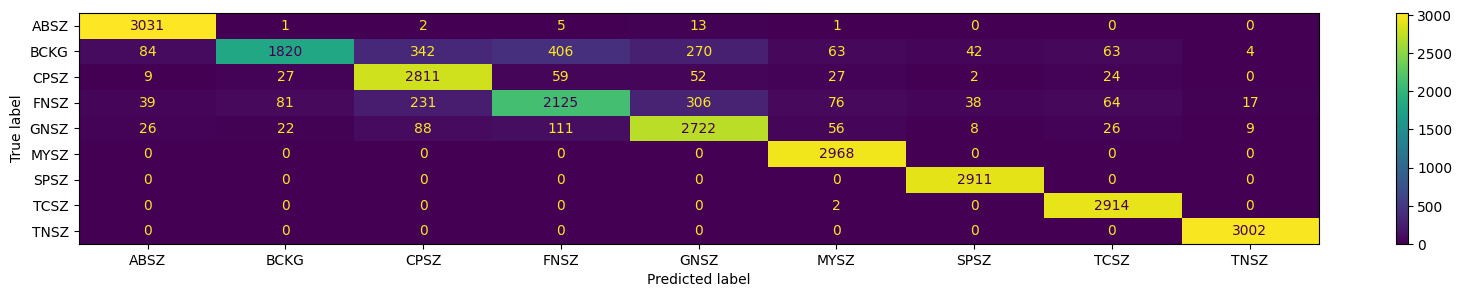

In [13]:
confusion_matrix = sklearn.metrics.confusion_matrix(y_true_val, y_pred_val)
cm_display = sklearn.metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = label_mapping)
#cm_display.plot()
plt.rcParams["figure.figsize"] = (20,3)
cm_display.plot()
plt.axis('tight')
plt.show()

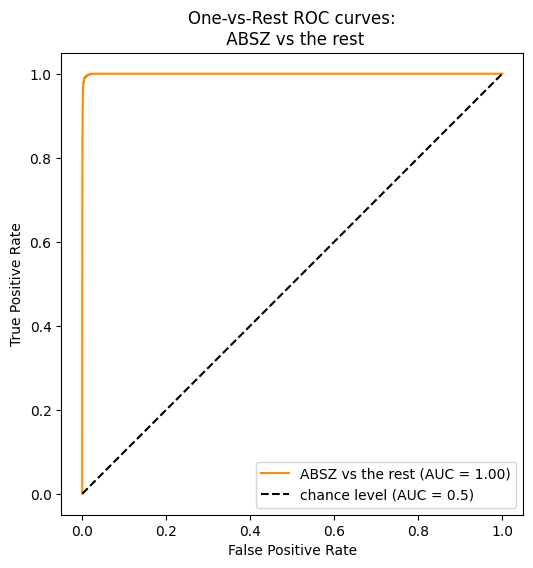

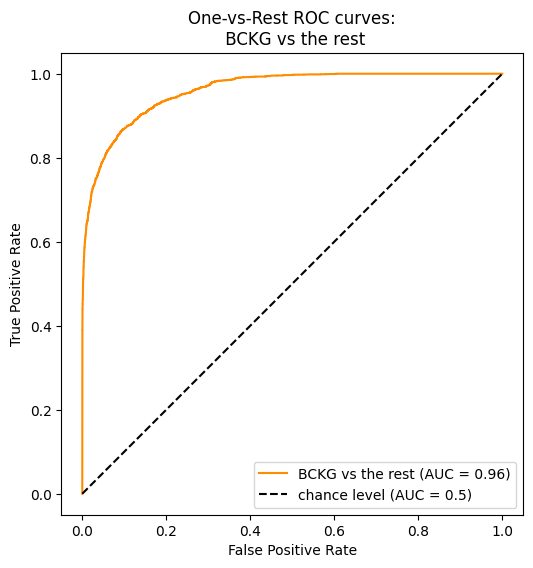

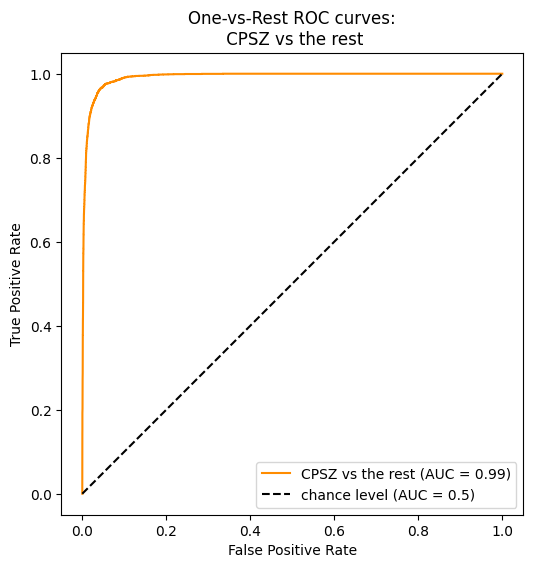

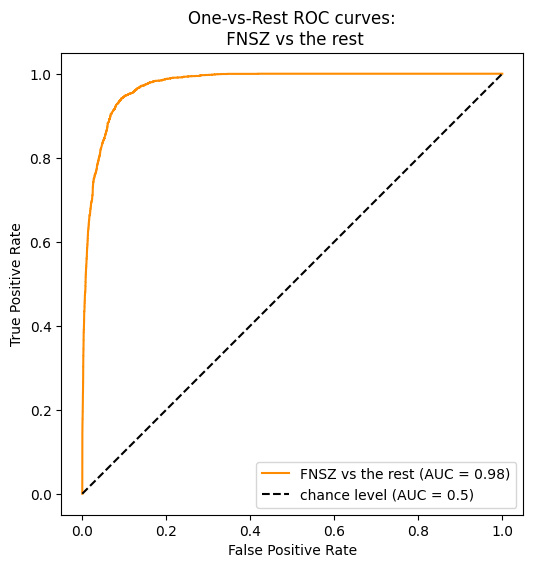

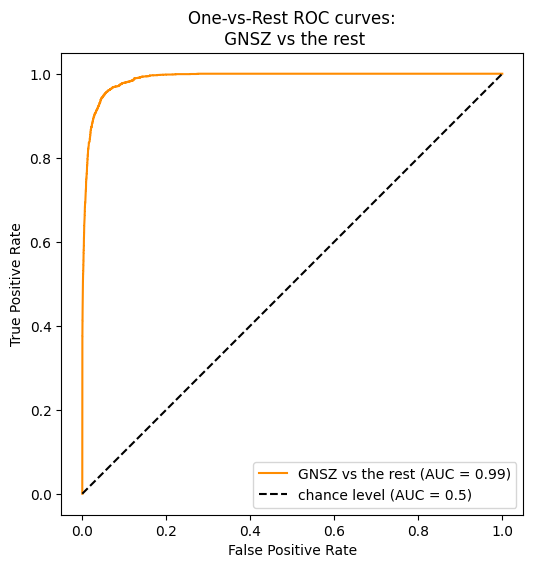

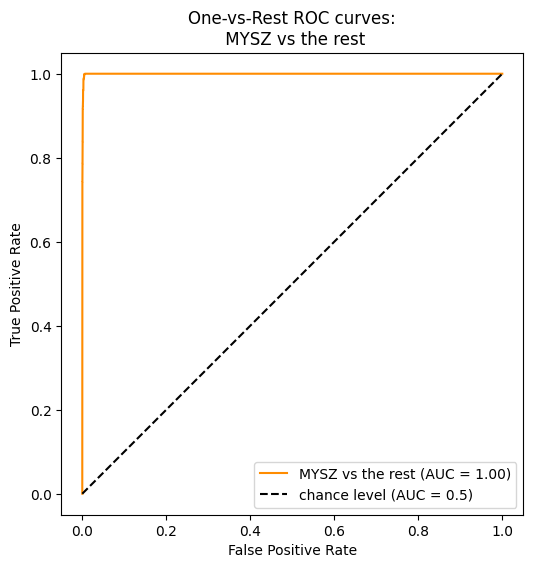

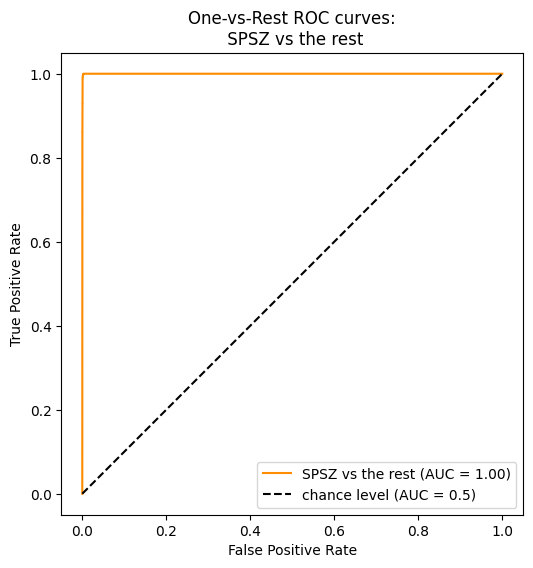

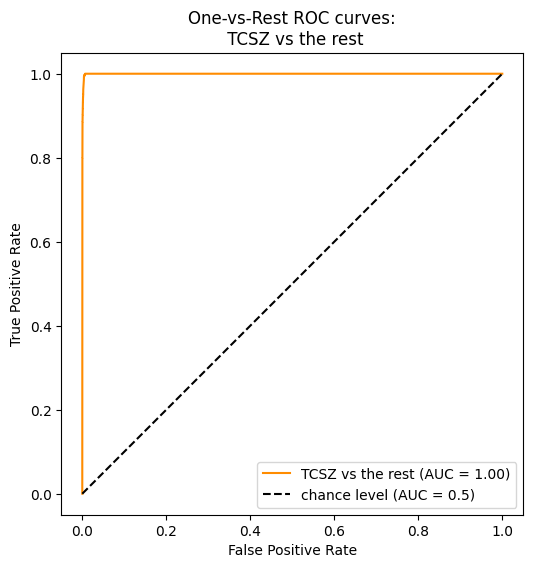

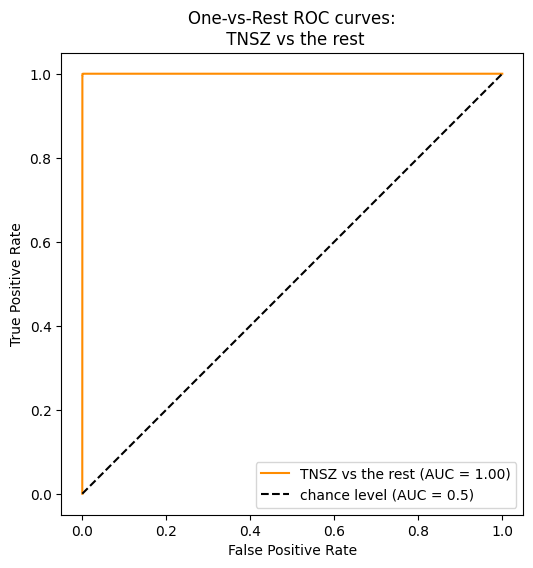

In [14]:
from sklearn.preprocessing import LabelBinarizer
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

label_binarizer = LabelBinarizer().fit(ytrain)
y_onehot_test = label_binarizer.transform(ytest)
plt.rcParams["figure.figsize"] = (6,6)
for lb in range(9):
    label_binarizer.transform([lb])
    class_of_interest = lb
    class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
    y_predicted = np.array(y_probs_val)
    RocCurveDisplay.from_predictions(
        y_onehot_test[:, class_id],
        y_predicted[:, class_id],
        name=f"{label_mapping[class_of_interest]} vs the rest",
        color="darkorange",
    )
    plt.plot([0, 1], [0, 1], "k--", label="chance level (AUC = 0.5)")
    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"One-vs-Rest ROC curves:\n {label_mapping[class_of_interest]} vs the rest")
    plt.legend()
    plt.show()

In [15]:
import pickle

filename = 'model.sav'
pickle.dump(model, open(filename, 'wb'))

from google.colab import files
files.download('model.sav') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>